In [1]:
#FILE CONTAINING:
# - Data formatting
# - RUNNING OF MODELS: XGBoost, Lasso, Prophet

import pandas as pd
from pathlib import Path
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from itertools import combinations

#Data Loading
NEWS_YOUTUBE = pd.read_csv('NEWSmYOUTUBE_V2.csv')
PAS = pd.read_csv('PAS_Weekly3.csv') #PAS + demographic
yearly = pd.read_csv('yearly_trends.csv') #yearly trends extracted from Prophet and added directly, to allow for implementation in XGBoost (+ Lasso)
pd.set_option('display.max_columns', None)
#display(PAS)

In [3]:
#converting to nearest monday

PAS['converted_date'] = pd.to_datetime(PAS['converted_date'])

def nearest_monday(date):
    days_until_monday = (0 - date.weekday() + 7) % 7
    days_since_last_monday = (date.weekday() - 0 + 7) % 7
    nearest_monday_date = date + pd.Timedelta(days=min(days_until_monday, days_since_last_monday))
    return nearest_monday_date

PAS['converted_date'] = PAS['converted_date'].apply(nearest_monday)
PAS['converted_date'] = PAS['converted_date'].astype(str)
PAS['converted_date'] = pd.to_datetime(PAS['converted_date'])

PAS['converted_date'] = PAS['converted_date'].apply(nearest_monday)
PAS['converted_date'] = PAS['converted_date'].astype(str)
PAS['converted_date'] = pd.to_datetime(PAS['converted_date'])

PAS['converted_date'] = PAS['converted_date'].apply(nearest_monday)
PAS['converted_date'] = PAS['converted_date'].astype(str)

MERGED = pd.merge(PAS, NEWS_YOUTUBE, left_on='converted_date', right_on = 'week', how='left')

#display(MERGED)

num_rows_with_nan = MERGED.isnull().any(axis=1).sum()
num_total_rows = MERGED.shape[0]

print(f'Number of total rows: {num_total_rows}')
print(f'Number of rows with at least one NaN value: {num_rows_with_nan}')

Number of total rows: 60451
Number of rows with at least one NaN value: 486


In [8]:
pd.set_option('display.max_columns', None)

#not relevant anymore, however was used when runnging model in Google BigCloud
def convert_column_names(df):
    new_column_names = {}
    for column_name in df.columns:
        new_column_name = column_name.replace(" ", "_")
        new_column_name = new_column_name.replace("-", "_")
        new_column_name = new_column_name.replace(":", "_")
        new_column_name = new_column_name.replace(".", "_")
        new_column_name = new_column_name.replace("/", "_")      
        new_column_name = new_column_name.replace("(", "_")
        new_column_name = new_column_name.replace(")", "_")      
        new_column_name = new_column_name.replace("'", "_")
        new_column_name = new_column_name.replace(",", "_")
        new_column_name = new_column_name.strip()
        new_column_name = new_column_name.lower()
        new_column_names[column_name] = new_column_name
    df.rename(columns=new_column_names, inplace=True)
    return df

MERGED = convert_column_names(MERGED)

def validate_column_names(df):
    invalid_columns = []
    for column_name in df.columns:
        if not column_name.isidentifier():
            invalid_columns.append(column_name)
    if len(invalid_columns) > 0:
        print("The following column(s) have invalid names:")
        for column in invalid_columns:
            print(column)
    else:
        print("All column names are valid.")

validate_column_names(MERGED)

#MERGED.to_csv("MERGED_V3.csv")
try:
    MERGED.drop(['unnamed__0_x', 'week'], axis=1, inplace=True)
except KeyError:
    pass

remove_said_cols = False

#gives option to remove certain columns to ease model training
columns_to_remove = ['pas_other', 'pas_other_1', 'pas_a_levels', 'pas_btec_level_1', 'pas_btec_level_2', 'pas_btec_level_3',
                     'pas_don_t_know', 'pas_hnc_or_hnd_btec_level_4', 'pas_nvq_gnvq', 'pas_no_qualifications', 'pas_not_asked', 'unnamed__0_y', 
                     'pas_o_levels_cse_gcses', 'pas_onc__ond_or_city_and_guilds', 'pas_other_2', 'pas_other___please_specify', 'pas_post_graduate_degree_or_qualification',
                    'pas_refused', 'pas_trade_apprenticeship', 'pas_university_degree__bachelor_degree_', 'pas_in_this_area__i_e__within_a_15_minute_walk_from_your_home_',
                    'pas_other_3', 'pas_no',  'pas_elsewhere_in_london', 'ytytunidentified_category'  ]
columns_to_remove2 = ['no_qualifications_x', 'level_1_and_entry_level_qualifications_x', 'level_2_qualifications_x', 'apprenticeship_x', 'level_3_qualifications_x', 'level_4_qualifications_and_above_x', 'other_qualifications_x', 'europe_x', 'europe__united_kingdom_x', 'europe__eu_countries_x', 'europe__eu_countries__european_union_eu14_x', 'europe__eu_countries__european_union_eu8_x', 'europe__eu_countries__european_union_eu2_x', 'europe__eu_countries__all_other_eu_countries_x', 'europe__non_eu_countries_x', 'europe__non_eu_countries__all_other_non_eu_countries_x', 'africa_x', 'middle_east_and_asia_x', 'the_americas_and_the_caribbean_x', 'antarctica_and_oceania__including_australasia__and_other_x', 'british_overseas__x', 'religion__no_religion_y', 'religion__christian_y', 'religion__buddhist_y', 'religion__hindu_y', 'religion__jewish_y', 'religion__muslim_y', 'religion__sikh_y', 'no_qualifications_y', 'level_1_and_entry_level_qualifications_y', 'level_2_qualifications_y', 'apprenticeship_y', 'level_3_qualifications_y', 'level_4_qualifications_and_above_y', 'other_qualifications_y', 'value__%__y', 'same_address_as_last_year_y', 'student_address_last_year_y', 'lived_elsewhere_in_uk_last_year_y', 'lived_outside_uk_last_year_y', 'europe_y', 'europe__united_kingdom_y', 'europe__eu_countries_y', 'europe__eu_countries__european_union_eu14_y', 'europe__eu_countries__european_union_eu8_y', 'europe__eu_countries__european_union_eu2_y', 'europe__eu_countries__all_other_eu_countries_y', 'europe__non_eu_countries_y', 'europe__non_eu_countries__all_other_non_eu_countries_y', 'africa_y', 'middle_east_and_asia_y', 'the_americas_and_the_caribbean_y', 'antarctica_and_oceania__including_australasia__and_other_y']

if remove_said_cols:
    MERGED = MERGED.drop(columns_to_remove, axis = 1)
    MERGED = MERGED.drop(columns_to_remove2, axis = 1)

display(MERGED)

The following column(s) have invalid names:
value__%__x
value__%__y


converted_date  q13  conservative_party  labour_party  \
0         2019-04-15  3.0            0.488529      0.338628   
1         2019-04-15  3.0            0.488529      0.338628   
2         2019-04-15  3.0            0.488529      0.338628   
3         2019-04-15  3.0            0.488529      0.338628   
4         2019-04-15  3.0            0.488529      0.338628   
...              ...  ...                 ...           ...   
60446     2017-04-10  4.0            0.375666      0.176363   
60447     2017-04-10  3.0            0.375666      0.176363   
60448     2017-04-10  3.0            0.375666      0.176363   
60449     2017-04-10  3.0            0.375666      0.176363   
60450     2017-04-10  3.0            0.375666      0.176363   

       liberal_democrats  green_party  religion__no_religion_x  \
0               0.159042     0.013801                 0.248370   
1               0.159042     0.013801                 0.248370   
2               0.159042     0.013801                 0.248370   
3               0.159042     0.013801                 0.248370   
4               0.159042     0.013801                 0.248370   
...                  ...          ...                      ...   
60446           0.410639     0.037331                 0.323264   
60447           0.410639     0.037331                 0.323264   
60448           0.410639     0.037331                 0.323264   
60449           0.410639     0.037331                 0.323264   
60450           0.410639     0.037331                 0.323264   

       religion__christian_x  religion__buddhist_x  religion__hindu_x  \
0                   0.483592              0.011201           0.011048   
1                   0.483592              0.011201           0.011048   
2                   0.483592              0.011201           0.011048   
3                   0.483592              0.011201           0.011048   
4                   0.483592              0.011201           0.011048   
...                      ...                   ...                ...   
60446               0.457737              0.008691           0.069958   
60447               0.457737              0.008691           0.069958   
60448               0.457737              0.008691           0.069958   
60449               0.457737              0.008691           0.069958   
60450               0.457737              0.008691           0.069958   

       religion__jewish_x  religion__muslim_x  religion__sikh_x  \
0                0.018699            0.117629          0.002225   
1                0.018699            0.117629          0.002225   
2                0.018699            0.117629          0.002225   
3                0.018699            0.117629          0.002225   
4                0.018699            0.117629          0.002225   
...                   ...                 ...               ...   
60446            0.001941            0.070292          0.002132   
60447            0.001941            0.070292          0.002132   
60448            0.001941            0.070292          0.002132   
60449            0.001941            0.070292          0.002132   
60450            0.001941            0.070292          0.002132   

       no_qualifications_x  level_1_and_entry_level_qualifications_x  \
0                 0.113503                                  0.044244   
1                 0.113503                                  0.044244   
2                 0.113503                                  0.044244   
3                 0.113503                                  0.044244   
4                 0.113503                                  0.044244   
...                    ...                                       ...   
60446             0.151651                                  0.092649   
60447             0.151651                                  0.092649   
60448             0.151651                                  0.092649   
60449             0.151651                            

In [9]:
#further formats dates and fills in NAs with 0s

try:
    MERGED['year'] = MERGED['converted_date'].str[:4].astype(int)
    MERGED['month'] = MERGED['converted_date'].str[5:7].astype(int)
    MERGED = MERGED.sort_values(by='converted_date')
    bool_columns = ['pas_barking_and_dagenham', 'pas_barnet', 'pas_bexley', 'pas_brent', 'pas_bromley', 'pas_camden', 'pas_croydon', 'pas_ealing', 'pas_enfield', 'pas_greenwich', 'pas_hackney', 'pas_hammersmith_and_fulham', 'pas_haringey', 'pas_harrow', 'pas_havering', 'pas_hillingdon', 'pas_hounslow', 'pas_islington', 'pas_kensington_and_chelsea', 'pas_kingston_upon_thames', 'pas_lambeth', 'pas_lewisham', 'pas_merton', 'pas_newham', 'pas_redbridge', 'pas_richmond_upon_thames', 'pas_southwark', 'pas_sutton', 'pas_tower_hamlets', 'pas_waltham_forest', 'pas_wandsworth', 'pas_westminster', 'pas_female', 'pas_male', 'pas_16_24', 'pas_25_34', 'pas_35_44', 'pas_45_54', 'pas_55_64', 'pas_65_or_over', 'pas_house_person', 'pas_not_working', 'pas_retired', 'pas_student_education', 'pas_unemployed', 'pas_working_ft', 'pas_working_pt', 'pas_outside_london', 'pas_asian', 'pas_black', 'pas_mixed', 'pas_white_british', 'pas_white_other', 'pas_non_uk', 'pas_uk', 'pas_yes', 'pas_christian', 'pas_hindu', 'pas_muslim', 'pas_no_religion', 'pas_other_religion', 'pas_heterosexual', 'pas_non_heterosexual']
    MERGED[bool_columns] = MERGED[bool_columns].astype(int)
except:
    pass

if remove_said_cols:
    MERGED[columns_to_remove] = MERGED[columns_to_remove].astype(int)
    MERGED[columns_to_remove2] = MERGED[columns_to_remove2].astype(int)

try:
    MERGED = pd.get_dummies(MERGED, columns=['year'])
    MERGED['converted_date'] = pd.to_datetime(MERGED['converted_date'])
    MERGED['date_no_year'] = MERGED['converted_date'].dt.strftime('%m-%d')
    MERGED = pd.merge(MERGED, yearly, left_on='date_no_year', right_on = 'converted_date', how='left')
    MERGED = MERGED.drop(columns=['date_no_year', 'converted_date_y'])

except:
    pass

MERGED.fillna(0, inplace=True)
display(MERGED[MERGED['converted_date_x'] != '2015-04-27'])

converted_date_x  q13  conservative_party  labour_party  \
258         2015-05-04  3.0            0.176116      0.806220   
259         2015-05-04  2.0            0.176116      0.806220   
260         2015-05-04  2.0            0.107842      0.603947   
261         2015-05-04  3.0            0.176116      0.806220   
262         2015-05-04  2.0            0.107842      0.603947   
...                ...  ...                 ...           ...   
60446       2019-12-30  2.0            0.437786      0.336415   
60447       2019-12-30  2.0            0.437786      0.336415   
60448       2019-12-30  3.0            0.437786      0.336415   
60449       2019-12-30  2.0            0.394620      0.353701   
60450       2019-12-30  3.0            0.437786      0.336415   

       liberal_democrats  green_party  religion__no_religion_x  \
258             0.004696     0.012968                 0.188201   
259             0.004696     0.012968                 0.188201   
260             0.056378     0.231833                 0.363167   
261             0.004696     0.012968                 0.188201   
262             0.056378     0.231833                 0.363167   
...                  ...          ...                      ...   
60446           0.191142     0.034657                 0.372565   
60447           0.191142     0.034657                 0.372565   
60448           0.191142     0.034657                 0.372565   
60449           0.119762     0.131917                 0.258802   
60450           0.191142     0.034657                 0.372565   

       religion__christian_x  religion__buddhist_x  religion__hindu_x  \
258                 0.453892              0.003751           0.030137   
259                 0.453892              0.003751           0.030137   
260                 0.306774              0.009041           0.007710   
261                 0.453892              0.003751           0.030137   
262                 0.306774              0.009041           0.007710   
...                      ...                   ...                ...   
60446               0.483201              0.006364           0.029225   
60447               0.483201              0.006364           0.029225   
60448               0.483201              0.006364           0.029225   
60449               0.488535              0.006068           0.059237   
60450               0.483201              0.006364           0.029225   

       religion__jewish_x  religion__muslim_x  religion__sikh_x  \
258              0.001243            0.243934          0.019574   
259              0.001243            0.243934          0.019574   
260              0.067244            0.133431          0.007204   
261              0.001243            0.243934          0.019574   
262              0.067244            0.133431          0.007204   
...                   ...                 ...               ...   
60446            0.002927            0.032958          0.003236   
60447            0.002927            0.032958          0.003236   
60448            0.002927            0.032958          0.003236   
60449            0.001559            0.104210          0.004233   
60450            0.002927            0.032958          0.003236   

       no_qualifications_x  level_1_and_entry_level_qualifications_x  \
258               0.227492                                  0.103570   
259               0.227492                                  0.103570   
260               0.167295                                  0.061021   
261               0.227492                                  0.103570   
262               0.167295                                  0.061021   
...                    ...                                       ...   
60446             0.137996                                  0.086877   
60447             0.137996                                  0.086877   
60448             0.137996                                  0.086877   
60449             0.160688    

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning

#LASSO REGRESSION

warnings.filterwarnings("ignore", category=ConvergenceWarning)

finding = True
min = 100
minr = -1

full_target_df = MERGED[MERGED[target_boroughs].any(axis=1)]
full_predictor_df = MERGED[MERGED[predictor_boroughs].any(axis=1)]

X = full_target_df.drop(columns=['q13', 'converted_date_x', 'pas_heterosexual', 'pas_male', 'month'])
y = full_target_df['q13']

#X = MERGED[['religion__no_religion_x', 'pas_enfield', 'pas_female', 'pas_16_24', 'pas_35_44', 'pas_45_54', 'pas_55_64', 'pas_retired', 'pas_working_ft', 'pas_working_pt', 'pas_asian', 'pas_black', 'pas_white_british', 'pas_hindu', 'pas_muslim', 'pas_other_religion', 'avg_sentiment', 'views', 'year_2019']]

# X.loc[:, 'i2'] = X['pas_female'] * X['religion__no_religion_x']
# X.loc[:, 'i3'] = X['pas_16_24'] * X['pas_16_24']
# X.loc[:, 'i4'] = X['pas_female'] * X['pas_working_pt']

#display(X)

for rs in range(1, 100):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=rs)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit the Lasso Regression model
    lasso = Lasso(alpha=0.001)
    lasso.fit(X_train_scaled, y_train)
    
    y_pred = lasso.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    
    r_squared = lasso.score(X_test_scaled, y_test)
  
    feature_importance = np.abs(lasso.coef_)
    important_features = np.array(X.columns)[feature_importance > 0.02]
 
    coefficients = pd.DataFrame(data=lasso.coef_, index=X.columns, columns=['Coefficient'])
    coefficients['AbsoluteCoefficient'] = np.abs(coefficients['Coefficient'])
    coefficients_sorted = coefficients.sort_values(by='AbsoluteCoefficient', ascending=False)

    if finding == False:
        print(f"Mean Squared Error: {mse}")
        print(f"R-squared: {r_squared}")
        print("Important features selected by Lasso Regression:")
        print(important_features)
        pd.set_option('display.max_rows', None)
        display(coefficients_sorted)
        pd.set_option('display.max_rows', 10)    


    # if mse < min:
    #     print("New Lowscore, MSE = : ", mse, " done on rs = ", rs)
    #     min = mse
    
    if finding == True:
        if r_squared > minr:
            print("New Highscore, R2 = : ", r_squared, " done on rs = ", rs)
            minr = r_squared

In [10]:
#segmenting variables

political_parties = ['conservative_party', 'labour_party', 'liberal_democrats', 'green_party']

# Religion
religions = ['religion__no_religion_x', 'religion__christian_x', 'religion__buddhist_x',
             'religion__hindu_x', 'religion__jewish_x', 'religion__muslim_x', 'religion__sikh_x']

# Other Values and Attributes
other_attributes = ['value__%__x', 'same_address_as_last_year_x', 'student_address_last_year_x',
                    'lived_elsewhere_in_uk_last_year_x', 'lived_outside_uk_last_year_x', 'british_overseas__y']

pas_boroughs = ['pas_barking_and_dagenham', 'pas_barnet', 'pas_bexley', 'pas_brent', 'pas_bromley', 'pas_camden',
                    'pas_croydon', 'pas_ealing', 'pas_enfield', 'pas_greenwich', 'pas_hackney', 'pas_hammersmith_and_fulham',
                    'pas_haringey', 'pas_harrow', 'pas_havering', 'pas_hillingdon', 'pas_hounslow', 'pas_islington',
                    'pas_kensington_and_chelsea', 'pas_kingston_upon_thames', 'pas_lambeth', 'pas_lewisham', 'pas_merton',
                    'pas_newham', 'pas_redbridge', 'pas_richmond_upon_thames', 'pas_southwark', 'pas_sutton', 'pas_tower_hamlets',
                    'pas_waltham_forest', 'pas_wandsworth', 'pas_westminster', 'pas_female', 'pas_male', 'pas_16_24', 'pas_25_34',
                    'pas_35_44', 'pas_45_54', 'pas_55_64', 'pas_65_or_over', 'pas_house_person', 'pas_not_working', 'pas_retired',
                    'pas_student_education', 'pas_unemployed', 'pas_working_ft', 'pas_working_pt', 'pas_outside_london', 'pas_asian',
                    'pas_black', 'pas_mixed', 'pas_white_british', 'pas_white_other', 'pas_non_uk', 'pas_uk', 'pas_yes',
                    'pas_christian', 'pas_hindu', 'pas_muslim', 'pas_no_religion', 'pas_other_religion', 'pas_heterosexual',
                    'pas_non_heterosexual']

pas_age = ['pas_16_24', 'pas_25_34', 'pas_35_44', 'pas_45_54', 'pas_55_64', 'pas_65_or_over']

# Social Sentiments and YouTube Metrics
social_sentiments_and_youtube_metrics = ['avg_sentiment_drugs', 'avg_sentiment_1_firearm', 'avg_sentiment_2_protest',
                                         'avg_sentiment_3_terrorism', 'avg_sentiment_4_theft', 'avg_sentiment_5_violence',
                                         'avg_sentiment', 'weighted_sentiment', 'num_comments', 'views', 'likes',
                                         'title_sentiment', 'description_sentiment', 'ytcommunity_relations', 'ytdrugs',
                                         'ytfirearm', 'ytillegal_immigration', 'ytlegal_and_policy', 'ytpolice_accountability',
                                         'ytprotest', 'ytterrorism', 'yttheft', 'ytviolence']

# social_sentiments_and_youtube_metrics = ['avg_sentiment_drugs', 'avg_sentiment_1_firearm', 'avg_sentiment_2_protest',
#                                          'avg_sentiment_3_terrorism', 'avg_sentiment_4_theft', 'avg_sentiment_5_violence',
#                                          'avg_sentiment']

# Years
years = ['year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019']

#PREPARATION FOR PROPHET

#display(MERGED)

def prepare_for_Prophet(dataf):
    
    MERGEDFB = dataf.rename(columns={'converted_date_x': 'ds', 'q13': 'y'})
    MERGEDFB_TRAIN = MERGEDFB[['ds', 'y']]
    MERGEDFB_TRAIN = MERGEDFB_TRAIN.rename(columns={'converted_date': 'ds', 'q13': 'y'})
    MERGEDFB_TRAIN = MERGEDFB_TRAIN.groupby('ds')['y'].mean().reset_index()
    
    MERGEDFB['ds'] = pd.to_datetime(MERGEDFB['ds'])
    MERGEDFB['ds'] = MERGEDFB['ds'] - pd.offsets.Week(weekday=0)
    MERGEDFB['ds'] = MERGEDFB['ds'].apply(lambda x: x if x.dayofweek == 0 else x + pd.Timedelta(days=(7 - x.dayofweek)))
    MERGEDFB['ds'] = MERGEDFB['ds'].dt.date
    
    MERGEDFB = MERGEDFB.groupby('ds')['y'].mean().reset_index()
    
    start_date = MERGEDFB['ds'].min()
    end_date = MERGEDFB['ds'].max()
    all_mondays = pd.date_range(start=start_date, end=end_date, freq='W-MON')
    missing_mondays = all_mondays[~all_mondays.isin(MERGEDFB['ds'])]
    missing_df = pd.DataFrame({'ds': missing_mondays})
    MERGEDFB = pd.concat([MERGEDFB, missing_df], ignore_index=True)
    MERGEDFB['ds'] = pd.to_datetime(MERGEDFB['ds'])
    MERGEDFB.sort_values('ds', inplace=True)
    MERGEDFB['y'] = MERGEDFB['y'].interpolate(method='linear')
    
    pd.set_option('display.max_rows', None)
    
    #display(MERGEDFB)
    return MERGEDFB

pd.set_option('display.max_rows', None)

display(stacked_df_pred)
MERGEDFB_pred = prepare_for_Prophet(stacked_df_pred)
display(MERGEDFB_pred)

MERGEDFB_targ = prepare_for_Prophet(stacked_df_targ)

#display(MERGEDFB_pred)
#display(stacked_df_pred)
#display(MERGEDFB_targ)

#political_parties ,pas_boroughs, religions, other_attributes, social_sentiments_and_youtube_metrics, years

NameError: name 'stacked_df_pred' is not defined

In [11]:
#display(ALL)

#Running of XGBOoost model

ALL = final_prep_prophet(target_b, predictor_bs, weights)

full_target_df = MERGED[MERGED[target_boroughs].any(axis=1)]
full_predictor_df = MERGED[MERGED[predictor_boroughs].any(axis=1)]

ALL['ds'] = pd.to_datetime(ALL['ds'])
filtered_data_after = ALL[ALL['ds'] > '2019-07-01']
filtered_data_after = filtered_data_after.iloc[::7]
filtered_data_before = ALL[ALL['ds'] <= '2019-07-01']
filt = pd.concat([filtered_data_before, filtered_data_after])

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

X = filt.drop(columns=['ds', 'y', 'month', 'unnamed__0_y', 'europe__eu_countries__european_union_eu8_x', 'europe__eu_countries__european_union_eu2_x',
                      'europe__eu_countries__european_union_eu8_y', 'europe__eu_countries__european_union_eu2_y'])#, 'pas_heterosexual', 'pas_male'])
y = filt['y']

#display(X)

#y = y.drop(y.index[[16, 29, 39, 167, 181, 225, 233, 251, 276, 354, 361, 417, 450, 479, 496, 512, 544, 568, 734, 751, 754, 834, 842, 942, 988, 1008, 1184, 1200, 1306, 1359, 1422, 1448, 1547, 1692, 1704, 1713, 1741, 1747, 1811, 1907, 2100, 2161, 2244, 2271, 2317, 2614, 2636, 2679, 2683, 2778, 2814, 2846, 2959]]).reset_index(drop=True)

finding = True
minr = -1

#display(X)

# nel = [400]
# lrl = [0.03]
# mdl = [2]
#Grid Search set-up
nel = [100, 200, 300]
lrl = [0.01, 0.02, 0.03]
mdl = [2, 3, 4, 5]

outliers_list = []

for rs in range(13, 14):
    for ne in nel:
        for lr in lrl:
            for md in mdl:
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs)

                #display(X_train, X_test)
                
                # split_index = int(0.95 * len(X))
                # X_train, X_test = X[:split_index], X[split_index:]
                # y_train, y_test = y[:split_index], y[split_index:]                
                
                xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',  # Specify the objective as squared error for regression
                                           n_estimators = ne,  # Number of boosting rounds
                                           learning_rate = lr,  # Step size shrinkage used to prevent overfitting
                                           max_depth = md)  # Maximum depth of a tree
                
                xg_reg.fit(X_train, y_train)
                
                y_pred = xg_reg.predict(X_test)
                
                mse = mean_squared_error(y_test, y_pred)
                
                residuals = y_test - y_pred
                
                residuals_array = residuals.values.reshape(-1, 1) if isinstance(residuals, pd.Series) else residuals.reshape(-1, 1)

                r2 = r2_score(y_test, y_pred)
                
                if finding == False:               
                    print(f"Mean Squared Error: {mse:.3f}")
                    print(f"R-squared: {r2:.3f}")
                    scaler = StandardScaler()
                    standardized_residuals = scaler.fit_transform(residuals_array).flatten()
                    outliers = np.where((standardized_residuals > 2) | (standardized_residuals < -2))[0]
                    outliers_list.extend(outliers.tolist())
                    #print("Indices of outliers:", outliers)
                    
                    feature_importances = xg_reg.feature_importances_
                    top10_indices = feature_importances.argsort()[-100:][::-1]
                    print("Top 100 Features:")
                    for i, idx in enumerate(top10_indices):
                        print(f"Feat{i+1}: {X.columns[idx]} - Imp: {feature_importances[idx]:.3f}")
                    
                else:
                    print(f"new r: {r2:.3f} on run: {rs}, ne = {ne}, lr = {lr}, md = {md}")
                    if r2 > minr:
                        minr = r2

outliers_counts = {i: outliers_list.count(i) for i in set(outliers_list)}
filtered_outliers = [key for key, value in outliers_counts.items() if value > 2]
print("Outliers that appeared more than twice:", filtered_outliers)



NameError: name 'final_prep_prophet' is not defined

In [12]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#

def convert_from_PAS_to_weekly(dataf):
    MERGED2 = dataf

    MERGED2['converted_date_x'] = pd.to_datetime(MERGED2['converted_date_x'])
    MERGED2.loc[:, 'converted_date_x'] = MERGED2['converted_date_x'].apply(lambda x: x - pd.Timedelta(days=x.dayofweek))
    MERGED2 = MERGED2.replace({True: 1, False: 0})
    averaged_df = MERGED2.groupby('converted_date_x').mean()
    averaged_df.reset_index(inplace=True)
    averaged_df['converted_date_x'] = pd.to_datetime(averaged_df['converted_date_x'])
    averaged_df = averaged_df[averaged_df['converted_date_x'] < '2019-07-01']

##pt. 1
    min_date = pd.to_datetime('2015-04-27')
    max_date = pd.to_datetime('2019-06-24')
    date_range = pd.date_range(start=min_date, end=max_date, freq='W-MON')
    new_rows = []
    
    for date in date_range:
        if date not in averaged_df['converted_date_x'].values:
            new_row = {'converted_date_x': date}
            for column in averaged_df.columns:
                if column != 'converted_date_x':
                    new_row[column] = np.nan
            new_rows.append(new_row)
    
    if new_rows:
        averaged_df = pd.concat([averaged_df, pd.DataFrame(new_rows)], ignore_index=True)
    
    averaged_df = averaged_df.sort_values('converted_date_x')
    averaged_df = averaged_df.interpolate()
    averaged_df = averaged_df.bfill().ffill()

##pt. 2    
    
    first_row = averaged_df.iloc[0].copy()
    first_row['converted_date_x'] -= pd.Timedelta(days=7)
    averaged_df = pd.concat([pd.DataFrame([first_row]), averaged_df], ignore_index=True)
    
    MERGED3 = dataf
    MERGED3 = MERGED3.replace({True: 1, False: 0})
    MERGED3['converted_date_x'] = pd.to_datetime(MERGED3['converted_date_x'])
    averaged_df_full = MERGED3.groupby('converted_date_x').mean()
    averaged_df_full.reset_index(inplace=True)
    
    averaged_df_full = averaged_df_full[averaged_df_full['converted_date_x'] > '2019-07-01']
    averaged_df_full = averaged_df_full[averaged_df_full['converted_date_x'] < '2019-12-24']
    
    averaged_df_full['converted_date_x'] = pd.to_datetime(averaged_df_full['converted_date_x'])
    
    min_date = pd.to_datetime('2019-07-01')
    max_date = pd.to_datetime('2019-12-23')
    date_range = pd.date_range(start=min_date, end=max_date)
    new_rows = []
    
    for date in date_range:
        if date not in averaged_df_full['converted_date_x'].values:
            new_row = {'converted_date_x': date}
            for column in averaged_df_full.columns:
                if column != 'converted_date_x':
                    new_row[column] = np.nan
            new_rows.append(new_row)
    
    if new_rows:
        averaged_df_full = pd.concat([averaged_df_full, pd.DataFrame(new_rows)], ignore_index=True)
    
    averaged_df_full = averaged_df_full.sort_values('converted_date_x')
    averaged_df_full = averaged_df_full.bfill().ffill()
    averaged_df_full = averaged_df_full.fillna(method='bfill').fillna(method='ffill')

    # averaged_df_full.iloc[0] = averaged_df_full.iloc[2]
    # averaged_df_full.iloc[1] = averaged_df_full.iloc[2]
    
    averaged_df_full.reset_index(drop=True, inplace=True)        
    stacked_df = pd.concat([averaged_df, averaged_df_full], axis=0, ignore_index=True)
    stacked_df = stacked_df.rename(columns={'converted_date_x': 'ds', 'q13': 'y'})

    stacked_df = stacked_df[~stacked_df['ds'].duplicated(keep=False)]
    
    return stacked_df


def final_prep_prophet(target_boroughs, predictor_boroughs, weights):
    full_target_df = MERGED[MERGED[target_boroughs].any(axis=1)]
    full_predictor_df = MERGED[MERGED[predictor_boroughs].any(axis=1)]
    
    stacked_df_targ = convert_from_PAS_to_weekly(full_target_df)
    
    temp = []
    count = 0
    for bor in predictor_boroughs:
        bor2 = MERGED[MERGED[[bor]].any(axis=1)]
        resu = convert_from_PAS_to_weekly(bor2)
        resu.iloc[:, 1:] *= weights[count]
        #print(resu.shape)
        temp.append(resu)
        count += 1
    
    combined_df = pd.concat(temp)
    
    #weighted sum of predictor variables
    weighted_sum = combined_df.groupby('ds').apply(lambda group: group.iloc[:, 1:].sum())
    weighted_sum = weighted_sum.reset_index()
        
    #display(weighted_sum)
    
    weighted_sum['y'] = stacked_df_targ['y']
    
#    display(weighted_sum)
    #print(weighted_sum['conservative_party'].sum())
    
    return weighted_sum


ds         y  conservative_party  labour_party  liberal_democrats  \
0   2015-04-20  2.728682            0.282215      0.479050           0.130017   
1   2015-04-27  2.728682            0.282215      0.479050           0.130017   
2   2015-05-04  2.634146            0.274479      0.444363           0.160827   
3   2015-05-11  2.724576            0.287926      0.498746           0.125945   
4   2015-05-18  2.718232            0.285346      0.458427           0.138520   
5   2015-05-25  2.734694            0.249307      0.493325           0.142890   
6   2015-06-01  2.837321            0.289412      0.477907           0.134425   
7   2015-06-08  2.731544            0.282186      0.462394           0.152207   
8   2015-06-15  2.752809            0.279473      0.474372           0.120381   
9   2015-06-22  2.756198            0.278824      0.454744           0.157816   
10  2015-06-29  2.803333            0.276804      0.470489           0.133719   
11  2015-07-06  2.686992            0.283497      0.481234           0.130526   
12  2015-07-13  2.753138            0.258668      0.486273           0.157097   
13  2015-07-20  2.767123            0.293520      0.461722           0.130862   
14  2015-07-27  2.779570            0.265130      0.476129           0.153839   
15  2015-08-03  2.684492            0.286593      0.458045           0.156302   
16  2015-08-10  2.672862            0.274255      0.491279           0.109166   
17  2015-08-17  2.740625            0.284239      0.460821           0.153936   
18  2015-08-24  2.781726            0.303309      0.450672           0.142349   
19  2015-08-31  2.798319            0.258214      0.516362           0.118798   
20  2015-09-07  2.740000            0.279753      0.453914           0.158587   
21  2015-09-14  2.728448            0.296843      0.456260           0.136524   
22  2015-09-21  2.673554            0.256742      0.483369           0.143375   
23  2015-09-28  2.673077            0.291565      0.457594           0.142094   
24  2015-10-05  2.630252            0.270880      0.480080           0.145112   
25  2015-10-12  2.784127            0.290394      0.459903           0.145322   
26  2015-10-19  2.768182            0.269930      0.489088           0.128827   
27  2015-10-26  2.793478            0.272014      0.479353           0.143246   
28  2015-11-02  2.744681            0.295519      0.458734           0.139538   
29  2015-11-09  2.649038            0.269389      0.489957           0.126778   
30  2015-11-16  2.728188            0.269596      0.458477           0.162870   
31  2015-11-23  2.622222            0.292423      0.468656           0.144188   
32  2015-11-30  2.580000            0.271306      0.453133           0.138218   
33  2015-12-07  2.674740            0.282578      0.495645           0.137425   
34  2015-12-14  2.664234            0.277873      0.466421           0.140278   
35  2015-12-21  2.713693            0.283607      0.463657           0.134578   
36  2015-12-28  2.757310            0.271528      0.467824           0.131909   
37  2016-01-04  2.782152            0.280379      0.473556           0.142118   
38  2016-01-11  2.843220            0.286639      0.478375           0.143362   
39  2016-01-18  2.866636            0.270872      0.478880           0.144150   
40  2016-01-25  2.890052            0.255104      0.479386           0.144938   
41  2016-02-01  2.721311            0.294371      0.484461           0.121797   
42  2016-02-08  2.744966            0.271164      0.475115           0.133090   
43  2016-02-15  2.706320            0.293336      0.459486           0.148738   
44  2016-02-22  2.761566            0.263087      0.473947           0.150302   
45  2016-02-29  2.709434            0.295638      0.461693           0.138676   
46  2016-03-07  2.664286            0.273262      0.478455           0.136158   
47  2016-03-14  2.710744            0.278143      0.470061           0.152883   
48  2016-03-21  2.733577            0.27438

23:47:29 - cmdstanpy - INFO - Chain [1] start processing
23:47:29 - cmdstanpy - INFO - Chain [1] done processing


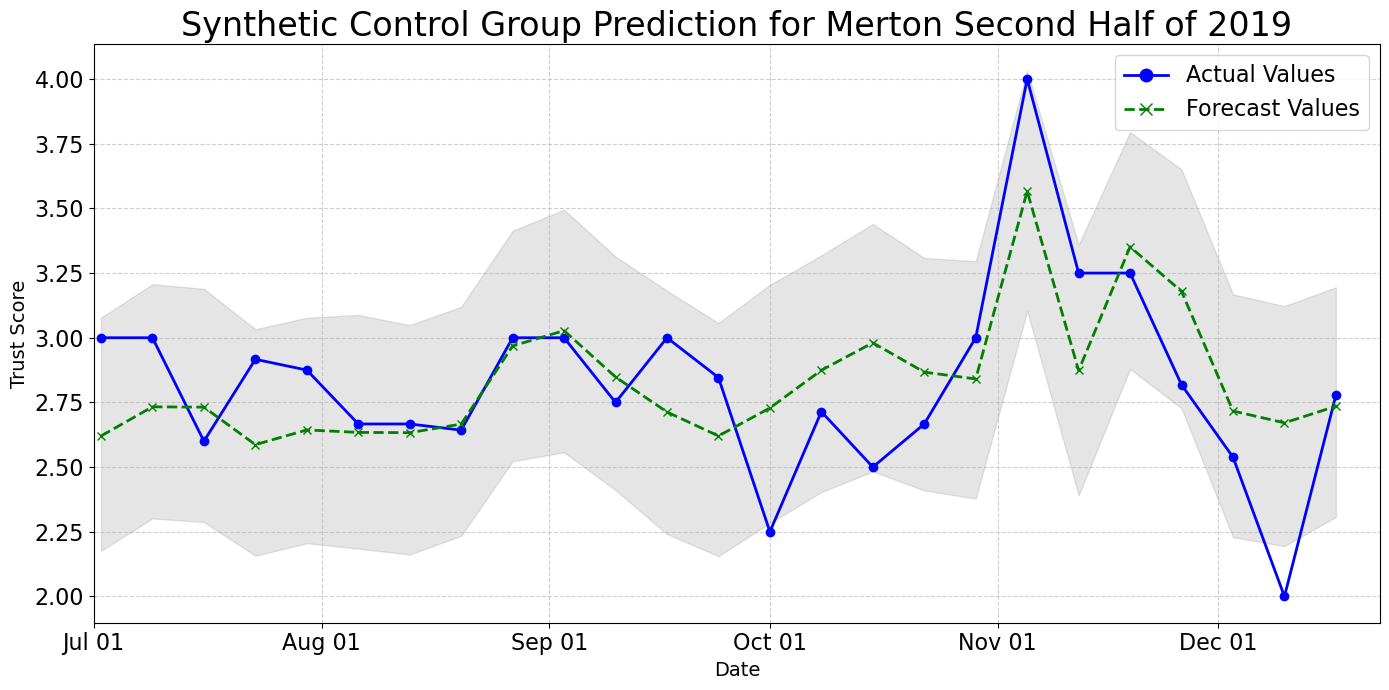

Explained Variance: 0.3821858100931328
Mean Squared Error (MSE): 0.08192482635766465
Mean Absolute Error (MAE): 0.2297200754744867
Mean Absolute Percentage Error (MAPE): 8.48307362445643
R-squared: 0.382107398961708


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.dates import DateFormatter

def runProphet(chosen_df, borough, fo):
    warnings.simplefilter(action='ignore', category=FutureWarning)
    chosen_date = '2019-07-01'
    
    pd.set_option('display.max_rows', 10)
    pd.set_option('display.max_columns', None)
    
    #chosen_df = weighted_sum
    #display(chosen_df)
    training_data = chosen_df[chosen_df['ds'] < chosen_date]
    
#    model = Prophet()
    model = Prophet(interval_width=0.90) 
    model.add_seasonality(name='yearly', period=365.25, fourier_order=fo)

    model.add_regressor('pas_no_religion')
    model.add_regressor('pas_male')
    model.add_regressor('pas_working_ft')
    model.add_regressor('ytviolence')
    model.add_regressor('avg_sentiment_1_firearm')
    model.add_regressor('avg_sentiment_4_theft')
    model.add_regressor('religion__jewish_x')
    #model.add_regressor('pas_non_heterosexual')
    model.add_regressor('avg_sentiment_3_terrorism')
    model.add_regressor('same_address_as_last_year_x')
    #model.add_regressor('description_sentiment')
    model.add_regressor('lived_elsewhere_in_uk_last_year_x')    
    
    model.fit(training_data)
    
    future = model.make_future_dataframe(periods=175)
    
    #future = pd.merge(future, stacked_df, left_on = 'ds', right_on = 'converted_date_x', how = 'left')
    #future = future.fillna(0)
    
    forecast = model.predict(chosen_df)
    
    # fig1 = model.plot(forecast)
    # fig2 = model.plot_components(forecast)
    
    test_data = chosen_df[chosen_df['ds'] > chosen_date]
    actual_values = test_data['y'].values
    actual_values = actual_values[::7]
    
    forecast_values = forecast.loc[forecast['ds'] > chosen_date, 'yhat'].values
    #print(len(forecast_values))
    
    forecast_values = forecast_values[0::7]

    lower_bound = forecast.loc[forecast['ds'] > chosen_date, 'yhat_lower'].values[0::7]
    upper_bound = forecast.loc[forecast['ds'] > chosen_date, 'yhat_upper'].values[0::7]
    
    plt.figure(figsize=(14, 7))  # Adjusted figure size for better aspect ratio
    
    # plt.plot(actual_values, label='Actual Values', marker='o', linestyle='-', color='blue', linewidth=2)
    # plt.plot(forecast_values, label='Forecast Values', marker='x', linestyle='--', color='green', linewidth=2)

    plt.plot(test_data['ds'].values[::7], actual_values, label='Actual Values', marker='o', linestyle='-', color='blue', linewidth=2)
    plt.plot(test_data['ds'].values[::7], forecast_values, label='Forecast Values', marker='x', linestyle='--', color='green', linewidth=2)
    plt.xlim(pd.to_datetime('2019-07-01'), pd.to_datetime('2019-12-31'))

    plt.fill_between(test_data['ds'].values[::7], lower_bound, upper_bound, color='gray', alpha=0.2)

    
    plt.title('Synthetic Control Group Prediction for Merton Second Half of 2019', fontsize=24)  # Title with increased font size
    plt.xlabel('Date', fontsize=14)  # X-axis label with increased font size
    plt.ylabel('Trust Score', fontsize=14)  # Y-axis label with increased font size
    
    plt.legend(fontsize=12)  # Legend with increased font size
    plt.grid(True, linestyle='--', alpha=0.6)  # Add grid lines with reduced opacity

    plt.fill_between(range(len(forecast_values)), lower_bound, upper_bound, color='gray', alpha=0.2)

    date_format = DateFormatter('%b %d')
    plt.gca().xaxis.set_major_formatter(date_format)

    plt.legend(fontsize=16, loc='best', markerscale=1.5)

    max_date = test_data['ds'].max()  # Get the maximum date from your test data
    plt.xlim(pd.to_datetime('2019-07-01'), max_date) 
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.tight_layout()  # Adjust layout to prevent clipping of labels

    plt.savefig('MERTON_V2.png', dpi=600, bbox_inches='tight')

    plt.show()
    
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    mse = mean_squared_error(actual_values, forecast_values)
    mae = mean_absolute_error(actual_values, forecast_values)
    mape = mean_absolute_percentage_error(actual_values, forecast_values)
    r_squared = r2_score(actual_values, forecast_values)
    explained_variance = 1 - (np.var(actual_values - forecast_values) / np.var(actual_values))
    
    print("Explained Variance:", explained_variance)
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Absolute Percentage Error (MAPE):", mape)
    print("R-squared:", r_squared)

    #print("For Borough: ", borough, "Explained Variance of ", explained_variance, "and an MAPE of ", mape)

    return explained_variance
    #return fig2

boroughs = ["pas_barnet", "pas_bexley", "pas_brent", "pas_bromley", "pas_camden", "pas_croydon", "pas_ealing", "pas_enfield", "pas_greenwich",
            "pas_hackney", "pas_hammersmith_and_fulham", "pas_haringey", "pas_harrow", "pas_havering", "pas_hillingdon", "pas_hounslow",
            "pas_islington", "pas_kensington_and_chelsea", "pas_kingston_upon_thames", "pas_lambeth", "pas_lewisham", "pas_merton",
            "pas_newham", "pas_redbridge", "pas_richmond_upon_thames", "pas_southwark", "pas_sutton", "pas_tower_hamlets", "pas_waltham_forest",
            "pas_wandsworth", "pas_westminster"]


target_b = ['pas_merton']
predictor_bs = ['pas_harrow', 'pas_bromley', 'pas_croydon', 'pas_brent']
weights = [0.7, 0.125, 0.125,  0.05]


# for i in predictor_bs:
#     predictor_bs = [i]
#     weights_df = final_prep_prophet(target_b, predictor_bs, weights)
#     runProphet(weights_df, i)

weights_df = final_prep_prophet(target_b, predictor_bs, weights)
#weights_df = final_prep_prophet(boroughs, boroughs, weights)

# whole_london = convert_from_PAS_to_weekly(MERGED)

expl_var = runProphet(weights_df, target_b, 15)
#expl_var = runProphet(whole_london, target_b, 28)
#print(expl_var)
# fig2 = runProphet(whole_london, target_b, 15)

In [282]:
# import itertools
# import random
# import logging

# logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
# random.seed(45)
# np.random.seed(45)

# def generate_random_weights(n):
#     weights = np.random.dirichlet(np.ones(n), size=1)[0]
#     return weights

# def random_combinations(boroughs, num_combinations=10):
#     max_boroughs = min(len(boroughs), 7)  # Ensure we don't select more than 7 boroughs
#     special_boroughs = ['pas_harrow']
    
#     for _ in range(num_combinations):
#         # Select a random borough to be the target
#         target_b = [random.choice(boroughs)]
#         target_b = ['pas_enfield']
        
#         # Ensure at least one special borough is included with a probability of at least 0.4
#         include_special = random.random() < 0.4
#         if include_special:
#             chosen_special = random.choice(special_boroughs)
#         else:
#             chosen_special = None

#         # Select a random number of predictor boroughs, ensuring it's at least 2
#         num_predictors = random.randint(2, min(max_boroughs - 1, len(boroughs) - 1))
        
#         # Ensure the special borough is included in predictor_bs if chosen_special is set
#         remaining_boroughs = [b for b in boroughs if b != target_b[0] and b != chosen_special]
#         predictor_bs = random.sample(remaining_boroughs, num_predictors - (1 if chosen_special else 0))
#         if chosen_special:
#             predictor_bs.append(chosen_special)
#             random.shuffle(predictor_bs)
        
#         # Generate random weights that sum to 1
#         weights = generate_random_weights(num_predictors)
        
#         yield target_b, predictor_bs, weights


# # Number of random combinations to generate
# num_combinations = 1000
# count = 0
# for target_b, predictor_bs, weights in random_combinations(boroughs, num_combinations):
#     count += 1
#     if count % 100 == 0:
#         print((100*count)/num_combinations, "% complete")
#     weights_df2 = final_prep_prophet(target_b, predictor_bs, weights)
#     expl_var2 = runProphet(weights_df2, target_b, 15)
#     if expl_var2 > 0.2:
#         print(f"Target Borough: {target_b[0]}")
#         print(f"Predictor Boroughs: {predictor_bs}")
#         print(f"Weights: {weights}")
#         print(f"Explained Variable: {expl_var2}\n")

In [58]:
import matplotlib.pyplot as plt
f1 = pd.DataFrame(forecast_values)
test_data = test_data.reset_index(drop=True)
merged_df = pd.merge(test_data,f1, left_index=True, right_index=True)
merged_df2 = pd.merge(test_data['ds'],f1, left_index=True, right_index=True)
#display(merged_df2)
plot_all_July = MERGEDFB_TRAIN[MERGEDFB_TRAIN['ds'] > '2019-07-01']
plot_all_July['ds'] = pd.to_datetime(plot_all_July['ds'])

mf = pd.merge(merged_df2, plot_all_July, on='ds', how='outer')

plt.figure(figsize=(10, 6))
plt.scatter(mf['ds'], mf['y'], label='Actual Values', color='b', marker='o', s = 10)
plt.plot(mf['ds'], mf[0], label='Predicted Values', color='r', linestyle='--')

# ds_numeric = mf['ds'].map(pd.Timestamp.timestamp)
# degree = 20
# fit = np.polyfit(ds_numeric, mf['y'], degree)
# fit_fn = np.poly1d(fit)
# ds_numeric_range = np.linspace(ds_numeric.min(), ds_numeric.max(), 500)
# plt.plot(pd.to_datetime(ds_numeric_range, unit='s'), fit_fn(ds_numeric_range), label='Best Fitting Curve', color='r')

new_ax.grid(True, linestyle='-', which='major', axis='y')
new_ax.grid(True, linestyle='--', which='major', axis='x')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

C:\Users\20211424\AppData\Local\Temp\ipykernel_18396\3940345545.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_all_July['ds'] = pd.to_datetime(plot_all_July['ds'])


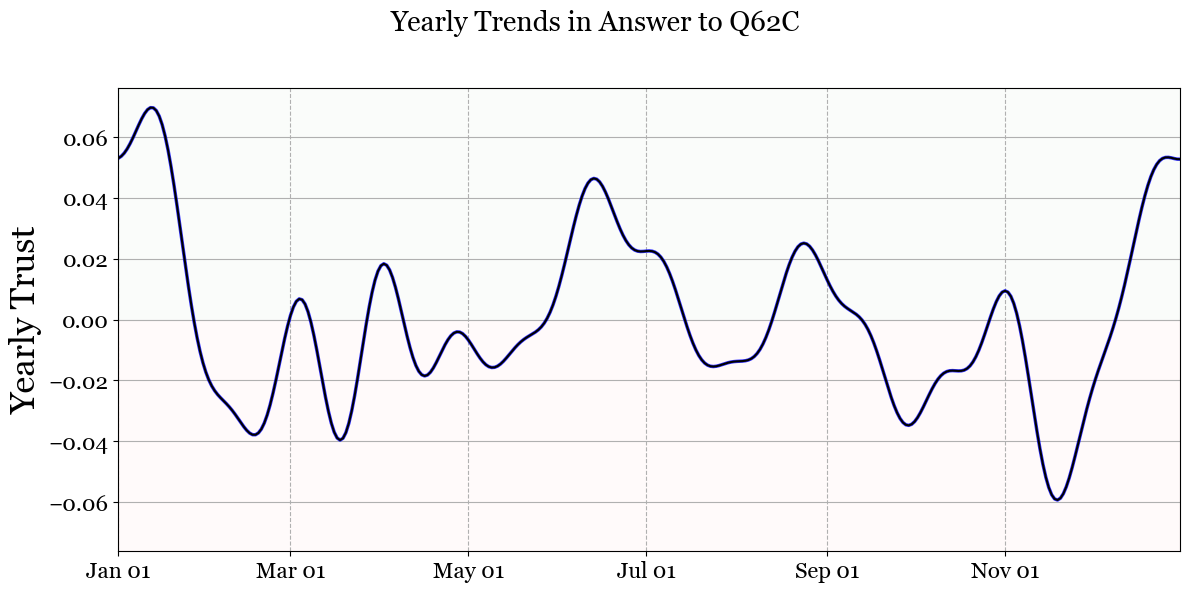

In [148]:
mpl.rcParams['font.family'] = 'Georgia'
second_ax = fig2.get_axes()[1]

fig, new_ax = plt.subplots(figsize=(12, 6))

for line in second_ax.get_lines():
    new_ax.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color='blue', linewidth=2.5 ,alpha = 0.8)  # Adjust line color and width

new_ax.set_title(second_ax.get_title(), fontsize=20)  # Increased font size for title
new_ax.set_xlabel(second_ax.get_xlabel(), fontsize=17)  # Increased font size for x-axis label
new_ax.set_ylabel(second_ax.get_ylabel(), fontsize=17)  # Increased font size for y-axis label

new_ax.set_xticks(second_ax.get_xticks())
new_ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

x_data = second_ax.get_lines()[0].get_xdata()
new_ax.set_xlim(min(x_data), max(x_data))

if second_ax.get_legend():
    new_ax.legend()

#new_ax.grid(True)

new_ax.set_xlabel("", fontsize=15)
new_ax.set_ylabel("Yearly Trust", fontsize=25)
new_ax.grid(True, linestyle='-', which='major', axis='y')
new_ax.grid(True, linestyle='--', which='major', axis='x')

y_min, y_max = new_ax.get_ylim()
y_limit = max(abs(y_min), abs(y_max))
new_ax.set_ylim(-y_limit, y_limit)

new_ax.axhspan(ymin=-y_limit, ymax=0, color='red', alpha=0.02)
new_ax.axhspan(ymin=0, ymax=y_limit, color='green', alpha=0.02)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

for line in second_ax.get_lines():
    new_ax.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color='black', linewidth=1.5)

fig.suptitle('Yearly Trends in Answer to Q62C', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

plt.show()

fig.savefig('ProphetYearlyTrends2.png', dpi=1000)

In [60]:
data = []
for line in second_ax.get_lines():
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    label = line.get_label()
    yearly = pd.DataFrame({'converted_date': x_data, 'trend': y_data})

yearly['converted_date'] = pd.to_datetime(yearly['converted_date'])
yearly['converted_date'] = yearly['converted_date'].dt.strftime('%m-%d')

display(yearly)

yearly.to_csv('yearly_trends.csv')

converted_date     trend
0            01-01  0.042066
1            01-02  0.041097
2            01-03  0.040030
3            01-04  0.038869
4            01-05  0.037620
..             ...       ...
360          12-27  0.045391
361          12-28  0.044998
362          12-29  0.044489
363          12-30  0.043866
364          12-31  0.043133

[365 rows x 2 columns]